# MAML reimplementation using TensorFlow 2.0

Reproduction of MAML using TensorFlow 2.0.

This  is highly influenced by the pytorch reproduction by Adrien Lucas Effot: [Paper repro: Deep Metalearning using “MAML” and “Reptile”](https://towardsdatascience.com/paper-repro-deep-metalearning-using-maml-and-reptile-fd1df1cc81b0)

Github: [https://github.com/mari-linhares/tensorflow-maml](https://github.com/mari-linhares/tensorflow-maml)

Twitter: [@hereismari](https://twitter.com/hereismari)

## MAML paper

https://arxiv.org/abs/1703.03400

**Model-Agnostic Meta-Learning for Fast Adaptation of Deep Networks**
*Chelsea Finn, Pieter Abbeel, Sergey Levine*

> We propose an algorithm for meta-learning that is model-agnostic, in the sense that it is compatible with any model trained with gradient descent and applicable to a variety of different learning problems, including classification, regression, and reinforcement learning. The goal of meta-learning is to train a model on a variety of learning tasks, such that it can solve new learning tasks using only a small number of training samples. In our approach, the parameters of the model are explicitly trained such that a small number of gradient steps with a small amount of training data from a new task will produce good generalization performance on that task. In effect, our method trains the model to be easy to fine-tune. We demonstrate that this approach leads to state-of-the-art performance on two few-shot image classification benchmarks, produces good results on few-shot regression, and accelerates fine-tuning for policy gradient reinforcement learning with neural network policies.

---

![image.png](https://cdn-images-1.medium.com/max/1600/1*EUt0H5AOEFkERg-OzfCC7A.png)


### TensorFlow installation

In [1]:
# !pip install -q tensorflow-gpu==2.0.0-alpha0  #for colab run

### Imports

In [1]:
%load_ext autoreload
%autoreload 2
import tensorflow as tf
import tensorflow.keras.backend as keras_backend
from tensorflow import keras
tf.keras.backend.set_floatx('float64')
# Other dependencies
import random
import sys
import time

import numpy as np
import matplotlib.pyplot as plt
plt.style.use(['dark_background'])
import matplotlib as mpl
# mpl.style.use('seaborn')
# from colorama import Fore
# Reproduction
np.random.seed(333)


print('Python version: ', sys.version)
print('TensorFlow version: ', tf.__version__)

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('GPU found at: {}'.format(device_name))

Python version:  3.7.6 (default, Jan  8 2020, 20:23:39) [MSC v.1916 64 bit (AMD64)]
TensorFlow version:  2.0.0
GPU found at: /device:GPU:0


In [2]:
# import functions for run

import train, train_maml
from sine_generator import SinusoidGenerator 
import generate_dataset, shuffled_batch 
from eval_sinewave_for_test import eval_sinewave_for_test
from  plot_model_comparison_to_average import plot_model_comparison_to_average
from  compare_maml_and_neural_net import compare_maml_and_neural_net
from save_model_weight import save_model_weight
from load_model_weight import load_model_weight 

from very_simple_model import SimpleSineModel

colors = {0:'dodgerblue' , 1: 'tomato' , 2:'forestgreen'}
keras.backend.backend()

'tensorflow'

In [17]:
import tensorflow.keras.backend  as K
x = tf.Variable(5, dtype=tf.float32)
K.sin(5*np.pi)
print(tf.sin(x))


tf.Tensor(-0.9589243, shape=(), dtype=float32)


## Section 5.1 Evaluating MAML on regression

> *We start with a simple regression problem that illustrates
the basic principles of MAML. Each task involves regressing
from the input to the output of a sine wave, where the
amplitude and phase of the sinusoid are varied between
tasks. Thus, p(T ) is continuous, where the amplitude
varies within [0.1, 5.0] and the phase varies within [0, π],
and the input and output both have a dimensionality of 1.
During training and testing, datapoints x are sampled uniformly
from [−5.0, 5.0].*

![]()

# Sinusoid Generator

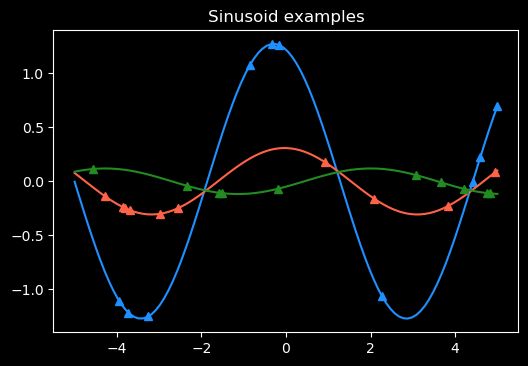

In [4]:
sine_generator = SinusoidGenerator(K=10)

fig = plt.figure(figsize=(6,4), dpi=100)
for i in range(3):

    sine_generator.plot(SinusoidGenerator(K=10), fig, title='Sinusoid examples', color=colors[i])


# Generate sinusoid datasets


In [5]:
train_ds, test_ds = generate_dataset.generate_dataset(K=10, test_size=25)
# num_batches = len(train_ds)
train_ds[0]

# Average test dataset

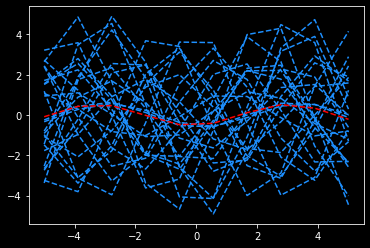

In [6]:
ts_ds = test_ds
# tr_ds, ts_ds = generate_dataset(K=10, test_size=25)
avg_pred =[]
x, _ = SinusoidGenerator(K=10).equally_spaced_samples()  
for i, sinusoid_generator in enumerate(ts_ds):
        _ , y = sinusoid_generator.equally_spaced_samples()
        plt.plot(x, y,'--', color=colors[0])
        avg_pred.append(y)
avg_plot, = plt.plot(x, np.mean(avg_pred, axis=0),'--', color='red')
plt.show()

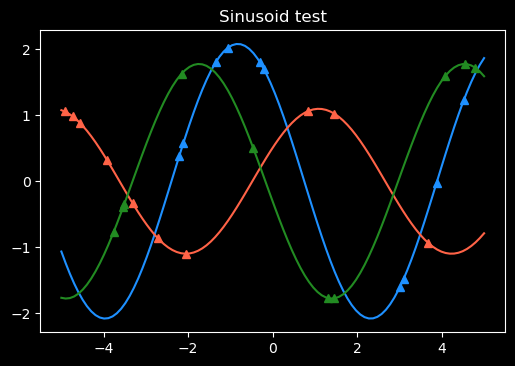

In [7]:
fig = plt.figure(figsize=(6,4), dpi=100)
for i in range(3):

    sine_generator.plot(test_ds[i], fig, title='Sinusoid test', color=colors[i])


# Training a regular Neural Network

We're training a Neural Network for given a batch of size *K* of randomly sampled values (*x*) predict *f(x)* where f is a sine wave function with amplitude randomly sampled within [0.1, 5.0] and the phase randomly sampled within [-π, π].

# Model definition


> *The regressor
is a neural network model with 2 hidden layers of size
40 with ReLU nonlinearities.*

In [8]:
from very_simple_model import SimpleSineModel

# Train 

Step 0: loss = 1.1857366787893253, Time to run 1000 steps = 0.43 seconds
Step 1000: loss = 4.448867155752421, Time to run 1000 steps = 7.47 seconds
Step 2000: loss = 4.3409878065111105, Time to run 1000 steps = 7.26 seconds
Step 3000: loss = 4.2795626050908595, Time to run 1000 steps = 7.20 seconds
Step 4000: loss = 4.249158985551848, Time to run 1000 steps = 7.12 seconds
Step 5000: loss = 4.245572312253904, Time to run 1000 steps = 7.80 seconds
Step 6000: loss = 4.254125051495999, Time to run 1000 steps = 7.16 seconds
Step 7000: loss = 4.241956241393679, Time to run 1000 steps = 7.27 seconds
Step 8000: loss = 4.248837515961266, Time to run 1000 steps = 7.17 seconds
Step 9000: loss = 4.248585258562992, Time to run 1000 steps = 7.20 seconds
Step 10000: loss = 4.248001370495206, Time to run 1000 steps = 7.16 seconds
Step 11000: loss = 4.255445360065906, Time to run 1000 steps = 7.38 seconds
Step 12000: loss = 4.261515058677678, Time to run 1000 steps = 7.17 seconds
Step 13000: loss = 4.2

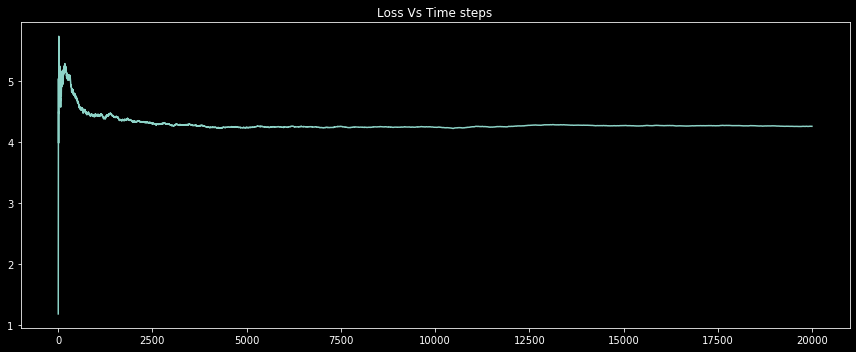

In [9]:
sine_model = SimpleSineModel()
neural_net = train.train_model(sine_model, train_ds)
# neural_net = train.train_model_shuffled(train_ds)

### A neural network trained for this task, should converge to the average of the sinusoids curves.

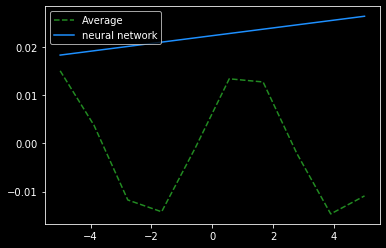

In [10]:
plot_model_comparison_to_average(model=neural_net, ds=train_ds)

### Transfer learning?

Here we try to use the trained neural network to initialize the weights for a model trained on new sine wave functions.

The new sine wave is treated as a new task. Our model was trained on a bunch of sine wave tasks and we're trying to use this previous knowledge to initialize the weights of the model for a new task.

### Try to use transfer learning for different sine waves

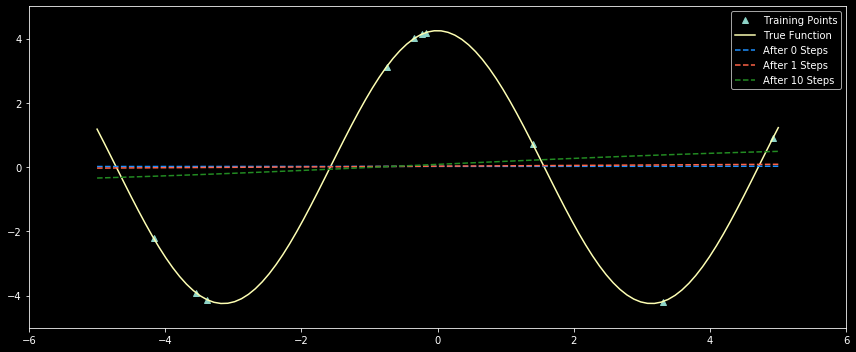

In [11]:
for index in np.random.choice(len(test_ds), size=1, replace=False):
    fit_res, w3_copied_model, weight_gradient, loss_finetune = eval_sinewave_for_test(neural_net, test_ds[index])

### MAML

![](https://cdn-images-1.medium.com/max/1600/1*_pgbRGIlmCRsYNBHl71mUA.png)

## Training MAML

It should take around 40 seconds to train for 1000 steps.

Step 1000: loss = 4.4739267335276445, Time to run 1000 steps = 36.52234482765198
Step 2000: loss = 4.388959779149161, Time to run 1000 steps = 36.348809003829956
Step 3000: loss = 4.334143964218161, Time to run 1000 steps = 37.80690860748291
Step 4000: loss = 4.325449512618099, Time to run 1000 steps = 38.58881664276123
Step 5000: loss = 4.245629146086267, Time to run 1000 steps = 36.90733337402344
Step 6000: loss = 4.210037492447007, Time to run 1000 steps = 36.77965331077576
Step 7000: loss = 4.200604605391086, Time to run 1000 steps = 36.590160608291626
Step 8000: loss = 4.205650277452415, Time to run 1000 steps = 36.52129411697388
Step 9000: loss = 4.232810153889461, Time to run 1000 steps = 37.999396085739136
Step 10000: loss = 4.224910769719367, Time to run 1000 steps = 36.2929573059082
Step 11000: loss = 4.2275310361460505, Time to run 1000 steps = 36.445552110672
Step 12000: loss = 4.212874397933873, Time to run 1000 steps = 36.36576008796692
Step 13000: loss = 4.21119664160061

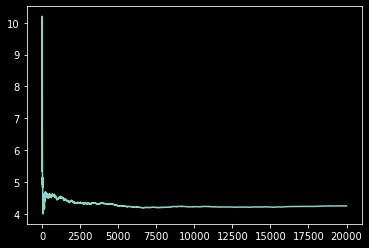

In [12]:
sine_model = SimpleSineModel()
maml = train_maml.train_maml(sine_model, 1, train_ds)

##  MAML model: compare average


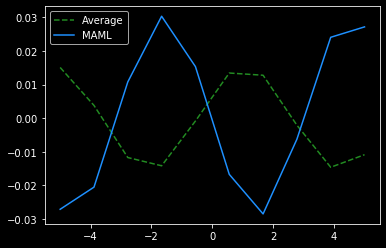

In [13]:
plot_model_comparison_to_average(maml, train_ds, model_name='MAML')

# Use MAML model to fit new sine wave

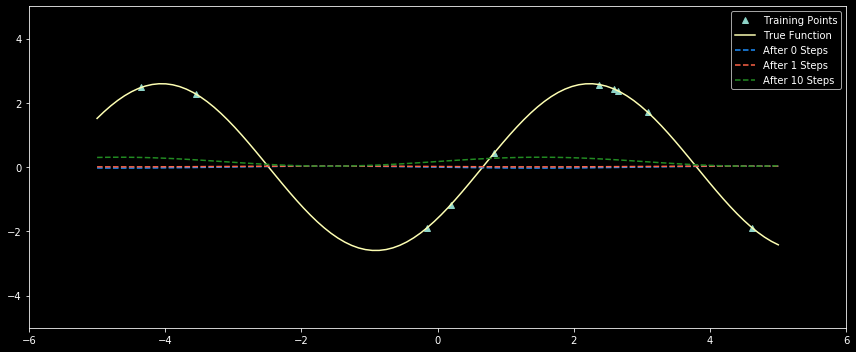

In [14]:
for index in np.random.choice(len(test_ds), size=1, replace=False):
    eval_sinewave_for_test(maml, test_ds[index])

# Save Model

In [15]:
save_model_weight(neural_net, path="./net/neural_net_model")
save_model_weight(maml, path="./maml/maml_model")

# Load Model

In [32]:
sinusoid_generator = SinusoidGenerator(K=10)
x, _ = sinusoid_generator.batch()
neural_net = load_model_weight(SimpleSineModel(), path="./net/neural_net_model", x=x)
maml = load_model_weight(SimpleSineModel(), path="./maml/maml_model", x=x)

print(neural_net.out.get_weights()[0].shape)
print(maml.out.get_weights()[0].shape)

(1, 1)
(1, 1)


# MAML vs Regular Neural Network

MAML


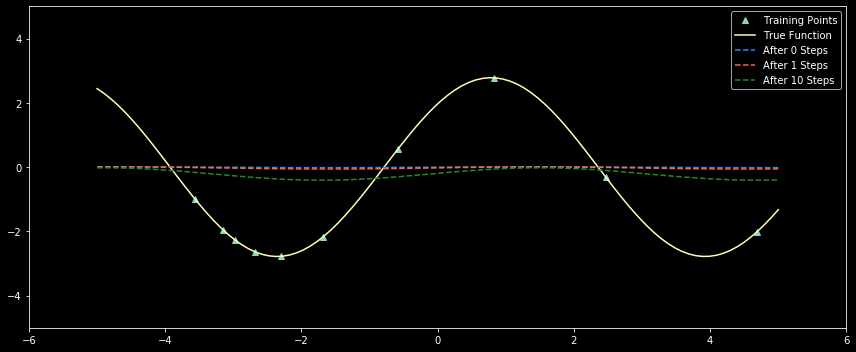

Neural Net


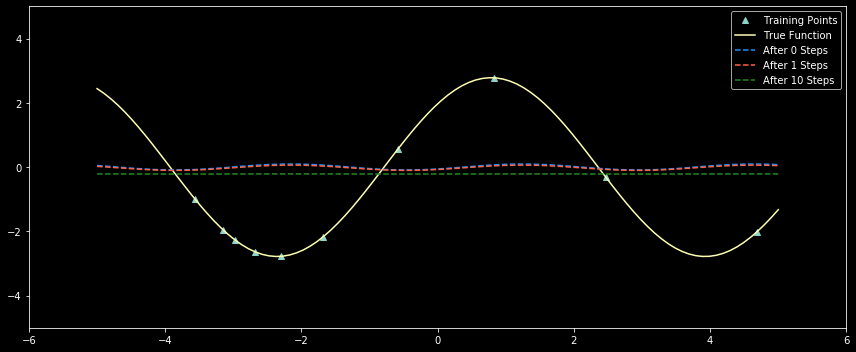

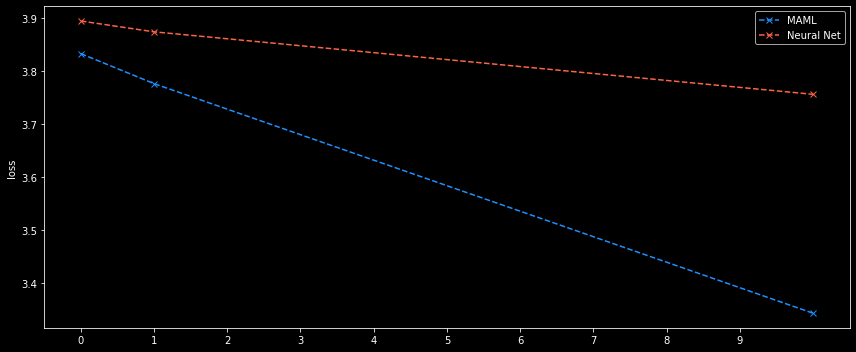

In [36]:
for _ in range(1):
    index = np.random.choice(range(len(test_ds)))
    w3_maml_model, w3_net_model, weight_gradient_net,\
     weight_gradient_maml, loss_net, loss_maml = compare_maml_and_neural_net(maml, neural_net, test_ds[index])

## weights of last layer of  models during fine-tuning

In [37]:
for i in range(len(w3_maml_model)):
    print(f'regular {i+1}:\n {w3_net_model[i]}, \nmaml {i+1}:\n{w3_maml_model[i]}')

regular 1:
 [[0.09214843]], 
maml 1:
[[0.01428416]]
regular 2:
 [[0.08183681]], 
maml 2:
[[0.03238205]]
regular 3:
 [[0.00176535]], 
maml 3:
[[0.19239718]]


# Difference of weights before fine-tuning and after

In [ ]:
w3 = neural_net.out.get_weights()[0]
# print(neural_net.out.get_weights())
for i in range(len(w3_net_model)):

    print(f'regular step{i}:\n {w3 - w3_net_model[i]}')

In [ ]:
w3_maml = maml.out.get_weights()[0]
for i in range(len(w3_maml_model)):

    print(f'maml step{i}:\n {w3_maml - w3_maml_model[i]}')

n:
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.] 
bin:
 [-0.48571584 -0.38571584 -0.28571584 -0.18571584 -0.08571584  0.01428416
  0.11428416  0.21428416  0.31428416  0.41428416  0.51428416]

 bin with most amount 0.014284160025096526
n:
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.] 
bin:
 [-0.46761795 -0.36761795 -0.26761795 -0.16761795 -0.06761795  0.03238205
  0.13238205  0.23238205  0.33238205  0.43238205  0.53238205]

 bin with most amount -0.06761794908386581
n:
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.] 
bin:
 [-0.30760282 -0.20760282 -0.10760282 -0.00760282  0.09239718  0.19239718
  0.29239718  0.39239718  0.49239718  0.59239718  0.69239718]

 bin with most amount 0.19239717965269437


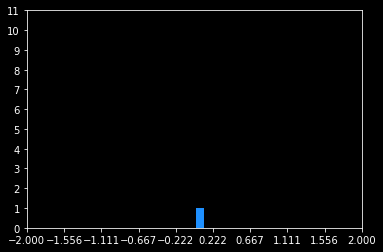

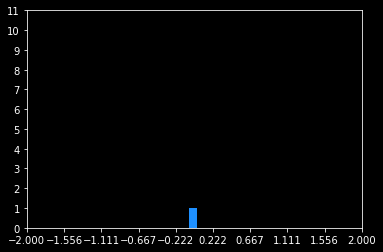

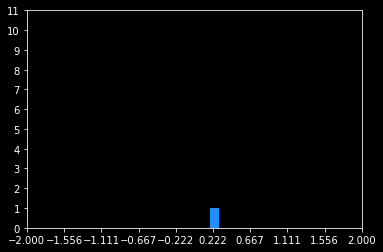

In [41]:
for i in range(len(w3_maml_model)):
    fig = plt.figure(i)
    data = plt.hist(w3_maml_model[i], facecolor='dodgerblue')
    plt.xticks(np.linspace(-2,2,10))
    plt.yticks(np.arange(0,12))
    n ,bin_ = data[0], data[1]
    print('n:\n', n,'\nbin:\n', bin_)
    print('\n bin with most amount', bin_[np.argmax(n)])

n:
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.] 
bin:
 [-0.5 -0.4 -0.3 -0.2 -0.1  0.   0.1  0.2  0.3  0.4  0.5]

 bin with most amount 0.0
n:
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.] 
bin:
 [-0.51809789 -0.41809789 -0.31809789 -0.21809789 -0.11809789 -0.01809789
  0.08190211  0.18190211  0.28190211  0.38190211  0.48190211]

 bin with most amount -0.018097890891037638
n:
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.] 
bin:
 [-0.67811302 -0.57811302 -0.47811302 -0.37811302 -0.27811302 -0.17811302
 -0.07811302  0.02188698  0.12188698  0.22188698  0.32188698]

 bin with most amount -0.17811301962759785


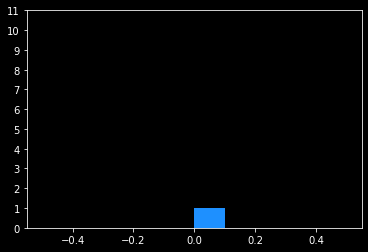

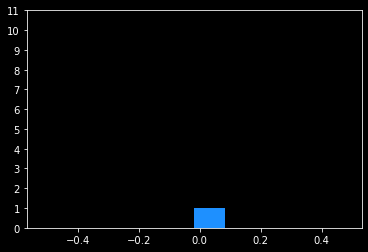

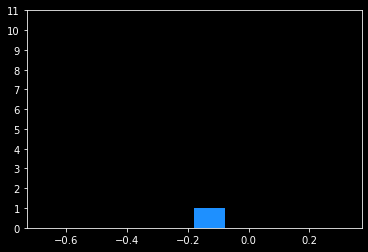

In [43]:
for i in range(len(w3_maml_model)):
    fig = plt.figure(i)
    data = plt.hist(w3_maml - w3_maml_model[i], facecolor='dodgerblue')
#     plt.xticks(np.linspace(-0.1,0.1,10))
    plt.yticks(np.arange(0,12))
    n ,bin_ = data[0], data[1]
    print('n:\n', n,'\nbin:\n', bin_)
    print('\n bin with most amount', bin_[np.argmax(n)])

![alt text](https://miro.medium.com/max/585/1*WmG_R90SyXjWwu6qPfwtQQ.png)